# Prediction Gain of Linear Prediction

This code is provided as supplementary material of the lecture Quellencodierung.

This code illustrates
* Calculation of the prediction gain
* Playback of the prediction error signal

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import lfilter
import librosa
import librosa.display
import IPython.display as ipd

Consider two different wave files

In [2]:
wave_filenames = ['../audio/33711__acclivity__excessiveexposure.wav', '../audio/E-Core - Pingouin-Banquise_45s.wav']

## First case: Fixed prediction coefficients
Calculate the prediction gain as
$$
G_{\mathsf{p}} = \frac{\sigma_x^2}{\sigma_x^2-\boldsymbol{\varphi}_{XX}^{\mathsf{T}}\boldsymbol{R}_{XX}^{-1}\boldsymbol{\varphi}_{XX}}
$$
where
$$
\boldsymbol{\varphi}_{XX} := \begin{pmatrix}
			\varphi_{XX}[1] \\
			\varphi_{XX}[2] \\			
			\vdots\\
			\varphi_{XX}[n]
			\end{pmatrix}
$$ 
and
$$
\boldsymbol{R}_{XX} := \begin{pmatrix}
			\varphi_{XX}[0] & \varphi_{XX}[-1] & \cdots & \varphi_{XX}[1-n] \\
			\varphi_{XX}[1] & \varphi_{XX}[0] & \cdots & \varphi_{XX}[2-n] \\
			\vdots & \vdots & \ddots & \vdots\\
			\varphi_{XX}[n-1] & \varphi_{XX}[n-2] & \cdots & \varphi_{XX}[0] \end{pmatrix}
$$
with 
$$
\varphi_{XX}[\lambda] = \mathbb{E}\left\{X[k]X[k-\lambda]\right\}
$$
being the auto-correlation of $X$.

In [3]:
# helper function calculating the correlation coefficient as defined in the lecture
def auto_correlation(x, k):
    if k >= 0:
        x_shift = np.roll(x,k)
        x_shift[:k] = 0
    else:
        x_shift = np.roll(x,k)
        x_shift[k:] = 0
        
    return np.correlate(x,x_shift)[0] / len(x)
    
# calculate prediction gain
def get_prediction_gain(x, n):
    if n == 0:
        return 1
    
    phi_XX = np.array([auto_correlation(x,k) for k in np.arange(1,n+1)])
    
    # inefficient way to calculate R_XX as many terms can be reused due to symmetric of the auto-correlation function
    R_XX = np.array([[auto_correlation(x,i-j) for j in range(n)] for i in range(n)])
    
    sigmaq_x = np.mean(np.square(x))    
    
    sigmaq_d = sigmaq_x - phi_XX.T @ np.linalg.inv(R_XX) @ phi_XX
    
    Gp = sigmaq_x / sigmaq_d
    return Gp

In [4]:
# compute prediction gains for two different audio files
Gp = {}
for wave_filename in wave_filenames:
    x, sampling_rate = librosa.load(wave_filename)
    n_range = range(31)
    Gp[wave_filename] = [get_prediction_gain(x,n) for n in n_range]
    print(sampling_rate)

22050
22050


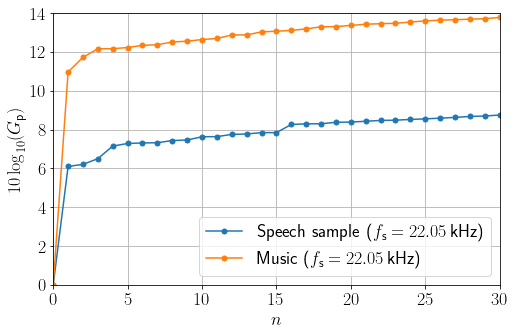

In [5]:
font = {'size'   : 18}
plt.rc('font', **font)
plt.rc('text', usetex=True)

plt.figure(figsize=(8, 5))

for wave_filename in wave_filenames:
    plt.plot(n_range, 10*np.log10(Gp[wave_filename]), ms=5, marker='o')
    
plt.xlim((0,30))
plt.ylim((0,14))
plt.xlabel('$n$')
plt.grid(True)
plt.ylabel('$10\log_{10}(G_{\mathsf{p}})$')
plt.legend(['Speech sample ($f_{\mathsf{s}}=22.05$\,kHz)', 'Music ($f_{\mathsf{s}}=22.05$\,kHz)'], loc=4)         
plt.savefig('figure_DST_6.6.pdf',bbox_inches='tight')

### Playback of prediction error signal

In [7]:
x, sampling_rate = librosa.load(wave_filenames[0])

# select a prediction filter of 10 coefficients
n = 1

sigmaq_x = np.mean(np.square(x))  
Gp_play = get_prediction_gain(x,n) 
sigmaq_d = sigmaq_x / Gp_play

phi_XX = np.array([auto_correlation(x,k) for k in np.arange(1,n+1)])
    
# inefficient way to calculate R_XX as many terms can be reused due to symmetric of the auto-correlation function
R_XX = np.array([[auto_correlation(x,i-j) for j in range(n)] for i in range(n)])

# optimal prediction coefficients
aopt = np.linalg.inv(R_XX) @ phi_XX

# generate prediction signal
xh = lfilter(np.concatenate(([0], aopt)), 1, x)

# prediction error
d = x - xh

# double-check filtering operation by comparing the predicted and real energy of the prediction error
sigmaq_d_est = np.mean(np.square(d))  
print(sigmaq_d)
print(sigmaq_d_est)

0.00019944033828628877
0.0001994395175463435


Playback original signal

In [8]:
# playback original audio
ipd.Audio(x, rate=sampling_rate)

Playback predicted signal

In [9]:
# playback original audio
ipd.Audio(xh, rate=sampling_rate)

Playback prediction error

In [10]:
# playback original audio
ipd.Audio(d, rate=sampling_rate)

Plot waveforms

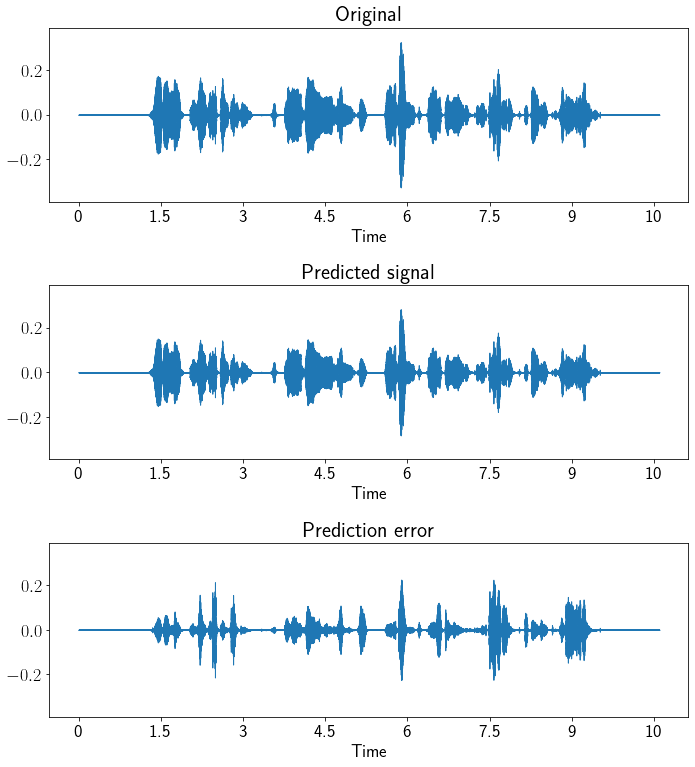

In [12]:
x_max = np.max([np.max(x), -np.min(x)])

plt.figure(figsize=(10, 11))
plt.subplot(3,1,1)
librosa.display.waveshow(x, sr=sampling_rate)
plt.title('Original')
plt.ylim((-x_max*1.2,+x_max*1.2))
plt.subplot(3,1,2)
librosa.display.waveshow(xh, sr=sampling_rate)
plt.title('Predicted signal')
plt.ylim((-x_max*1.2,+x_max*1.2))
plt.subplot(3,1,3)
librosa.display.waveshow(d, sr=sampling_rate)
plt.title('Prediction error')
plt.ylim((-x_max*1.2,+x_max*1.2))
plt.tight_layout()